# Classification - Part 1: Binary Classification and Performance Meaures

# 0. MNIST Dataset

1. Importing modules and MNIST dataset
2. Setting `plot_digit` function

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

The MNIST dataset from `fetch_openml()` is already split into training set (first 60,000 images) and test set (last 10,000 images):

In [2]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 0.1. Random Number Generator

In [3]:
import random

Select a random number from the dataset to work with

rng: 63522
selected number: 2


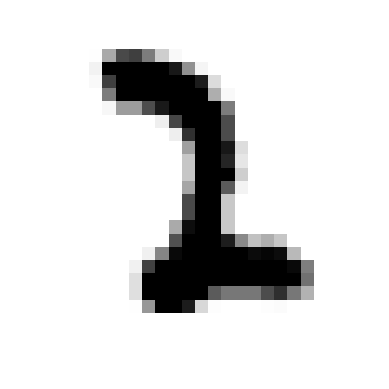

In [4]:
rng=random.randint(60000, 70000)
print('rng:', rng)
print('selected number:', y[rng])
plot_digit(X[rng])

Generate a random number to use as random state for the classifiers

In [5]:
rng_state=random.randint(0, 2**32 - 1)
rng_state

3249207879

## 0.2. Preview the first 100 entries in a 10×10 grid

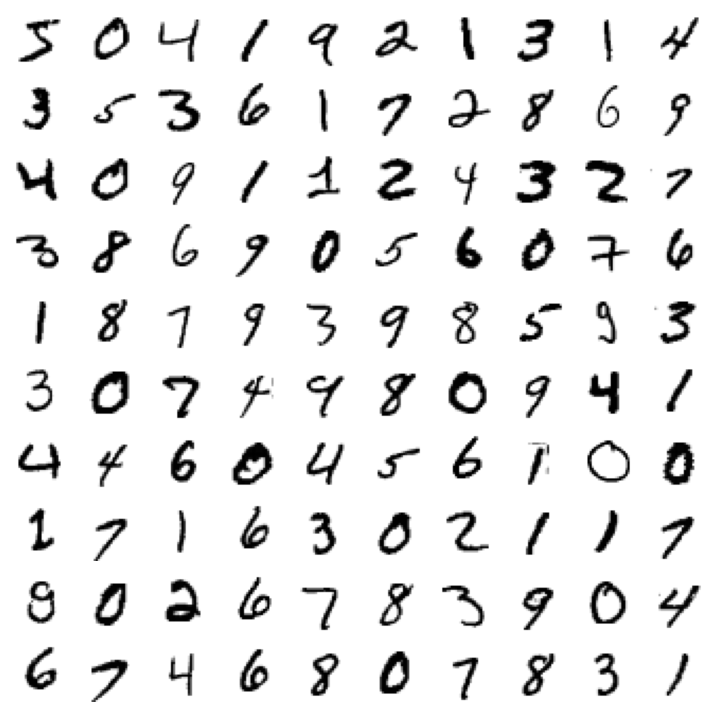

In [6]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

# 1. Binary Classification

To create a binary classifier, further slice the sets into the number selected through `rng`

The resultant `y_train_select` and `y_test_select` are boolean arrays where:
- value is `true` for `y_train[#]` or `y_test[#]` *is* a selected number
- value is `false` for `y_train[#]` or `y_test[#]` *is not* a selected number

In [7]:
y_train_select = (y_train == y[rng])
y_test_select = (y_test == y[rng])

Create a stochastic gradient descent (SGD) classifier with Scikit-Learn's `SGDClassifier` class and train (`fit`) it against the sliced dataset

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=rng_state)
sgd_clf.fit(X_train, y_train_select)

SGDClassifier(random_state=3249207879)

Verify the trained model by asking it to predict the number selected through `rng` above (the result should be `true`)

In [9]:
sgd_clf.predict([X[rng]])

array([ True])

# 2. Performance Measures

## 2.1. Cross-Validation Score

### 2.1.1. Measuring Accuracy Using Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_select, cv=3, scoring='accuracy')

array([0.9627 , 0.97465, 0.9651 ])

### 2.1.2. Cross-Validation Using Dummy Classifier
A dummy classifier classifies every single image in the most frequent class (i.e. every number other than the rng selected number)

In [11]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_select)
print(any(dummy_clf.predict(X_train)))

False


In [12]:
cross_val_score(dummy_clf, X_train, y_train_select, cv=3, scoring='accuracy')

array([0.9007, 0.9007, 0.9007])

### 2.1.3. "Manual" Cross-Validation Using Stratified K-Fold

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_select):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_select[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_select[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9627
0.97465
0.9651


## 2.2.Confusion Matrices

Count the number of times instances of class `A` are classified as class `B`, for all `A`/`B` pairs

`cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores like `cross_val_score()`, it returns the predictions made on each test fold

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_select, cv=3)

||Predicted Negative|Predicted Positive|
|---|---|---|
|**Actual Negative**|True Negative|False Positive|
|**Actual Positive**|False Negative|True Positive|

$Precision=\frac{\text{True Positives}}{\text{True Positives + False Positives}}$

$Recall=\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_select, y_train_pred)
cm

array([[53154,   888],
       [ 1063,  4895]])

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have non-zero values only on its main diagonal (top left to bottom right):

In [16]:
y_train_perfect_predictions = y_train_select # pretend we reached perfection
confusion_matrix(y_train_select, y_train_perfect_predictions)

array([[54042,     0],
       [    0,  5958]])

## 2.3. Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics:

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

Precision score

In [18]:
precision_score(y_train_select, y_train_pred)

0.846446481065191

Recall score

In [19]:
recall_score(y_train_select, y_train_pred)

0.8215844243034576

$F_{1}$ score (harmonic mean of precision and recall)

In [20]:
f1_score(y_train_select, y_train_pred)

0.833830167788093

### 2.3.1. The Precision/Recall Trade-off

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions

In [21]:
y_score = sgd_clf.decision_function([X[rng]])
y_score

array([5741.77140874])

Threshold ↑ ⇒ recall ↑, precision ↓

If `y_score` is **higher** than threshold, the decision will be `true`:

In [22]:
lower_threshold = y_score - y_score * 2
y_score > lower_threshold

array([ True])

Threshold ↓ ⇒ recall ↓, precision ↑

If `y_score` is **lower** than threshold, the decision will be `false`:

In [23]:
higher_threshold = y_score + y_score * 2
y_score > higher_threshold

array([False])

Using `method=decision_function` with `cross_val_predict()` to retrieve decision scores of all instances in the training set

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_select, cv=3, method='decision_function')

`precision_recall_curve()` function computes precision and recall for all possible thresholds using the scores from `cross_val_predict()`

The function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_select, y_scores)

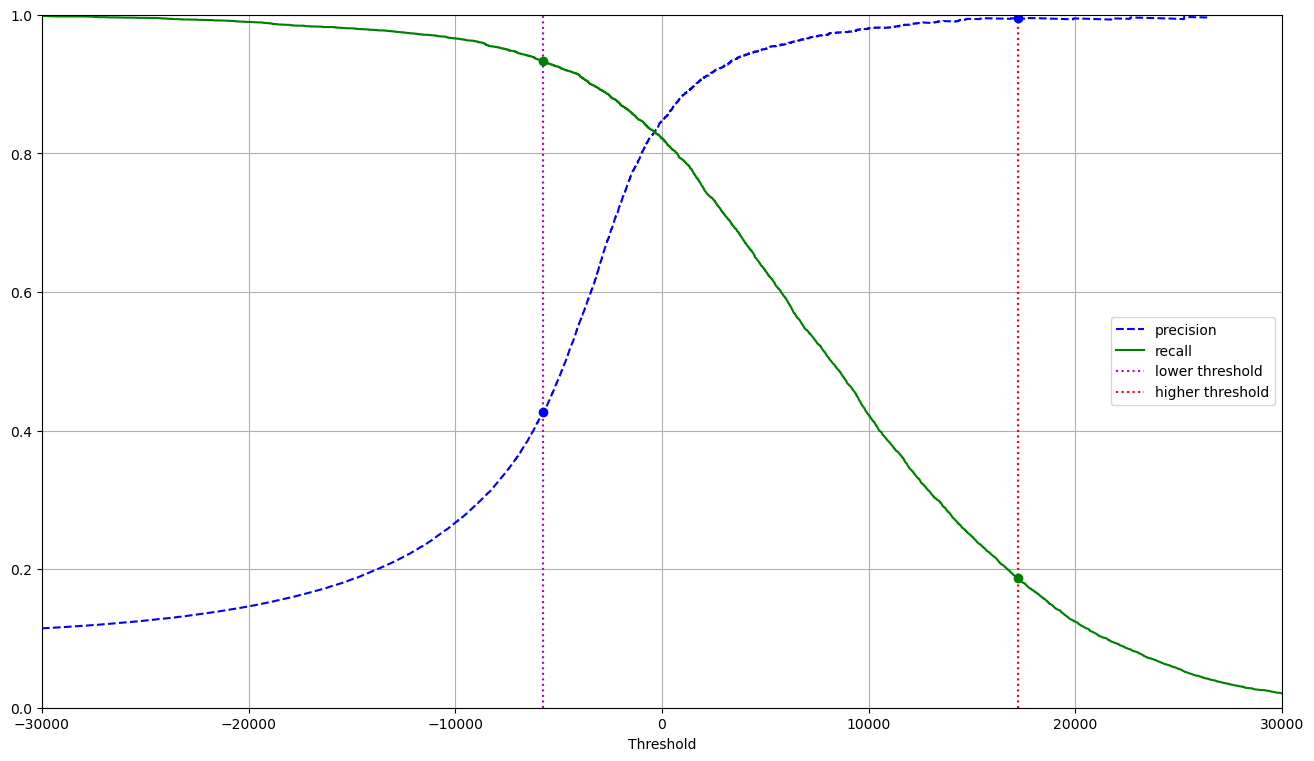

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
plt.vlines(lower_threshold, 0, 1.0, 'm', 'dotted', label='lower threshold')
plt.vlines(higher_threshold, 0, 1.0, 'r', 'dotted', label='higher threshold')

# marking intercepts of the curves and lower_threshold
idx_low = (thresholds >= lower_threshold).argmax()
plt.plot(thresholds[idx_low], precisions[idx_low], 'bo')
plt.plot(thresholds[idx_low], recalls[idx_low], 'go')

# marking intercepts of the curves and higher_threshold
idx_high = (thresholds >= higher_threshold).argmax()
plt.plot(thresholds[idx_high], precisions[idx_high], 'bo')
plt.plot(thresholds[idx_high], recalls[idx_high], 'go')

plt.axis([-30000, 30000, 0, 1])
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc='center right')

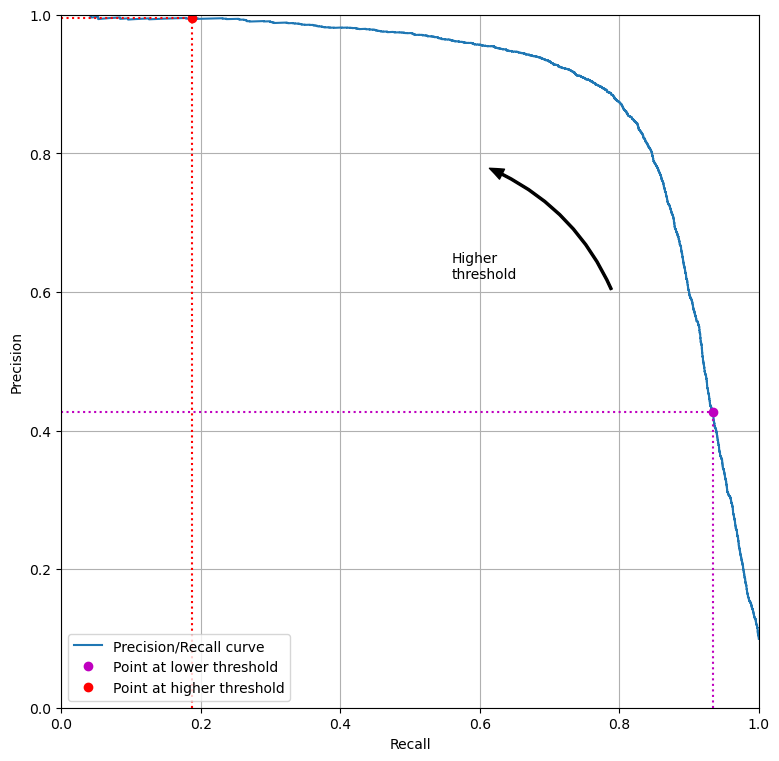

In [27]:
plt.figure(figsize=(9, 9))
plt.plot(recalls, precisions, label='Precision/Recall curve')

plt.plot([recalls[idx_low], recalls[idx_low]], [0., precisions[idx_low]], 'm:')
plt.plot([0.0, recalls[idx_low]], [precisions[idx_low], precisions[idx_low]], 'm:')
plt.plot([recalls[idx_low]], [precisions[idx_low]], 'mo', label='Point at lower threshold')

plt.plot([recalls[idx_high], recalls[idx_high]], [0., precisions[idx_high]], 'r:')
plt.plot([0.0, recalls[idx_high]], [precisions[idx_high], precisions[idx_high]], 'r:')
plt.plot([recalls[idx_high]], [precisions[idx_high]], 'ro', label='Point at higher threshold')

import matplotlib.patches as patches
plt.gca().add_patch(patches.FancyArrowPatch(
  (0.79, 0.60), (0.61, 0.78),
  connectionstyle='arc3,rad=.2',
  arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
  color='k'))
plt.text(0.56, 0.62, 'Higher\nthreshold', color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower left')

#### 2.3.1.1. Recall at 90% precision

Getting the threshold for 90% precision:

In [28]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

1658.4478636652402

Verify precision score for 90% precision:

In [29]:
y_train_pred_90_precision = (y_scores >= threshold_for_90_precision)
precision_score(y_train_select, y_train_pred_90_precision)

0.9001578531965272

Recall at 90% precision:

In [30]:
recall_at_90_precision = recall_score(y_train_select, y_train_pred_90_precision)
recall_at_90_precision

0.7656931856327627

#### 2.3.1.2. Precision at 90% recall

Getting the threshold for 90% recall:

In [31]:
idx_for_90_recall = (recalls >= 0.90).argmin()
threshold_for_90_recall = thresholds[idx_for_90_recall]
threshold_for_90_recall

-3443.1777080540264

Verify precision score for 90% recall:

In [32]:
y_train_pred_90_recall = (y_scores >= threshold_for_90_recall)
recall_score(y_train_select, y_train_pred_90_recall)

0.8999664316884861

Recall at 90% precision:

In [33]:
precision_at_90_recall = precision_score(y_train_select, y_train_pred_90_recall)
precision_at_90_recall

0.5991730919655828

## 2.4. The ROC curve

- Precision/recall curve: precision vs recall
- Receiver operating characteristic (ROC) curve: TPR vs FPR

#### True Positive Rate (TPR) or Recall

Proportion of actual positives that are correctly identified by the model

$Recall=\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

#### False Positive Rate (FPR) or Fall-Out

Proportion of actual negatives that are incorrectly identified as positives by the model

$\text{Fall-Out}=\frac{\text{False Positives}}{\text{False Positives + True Negatives}}$

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_select, y_scores)

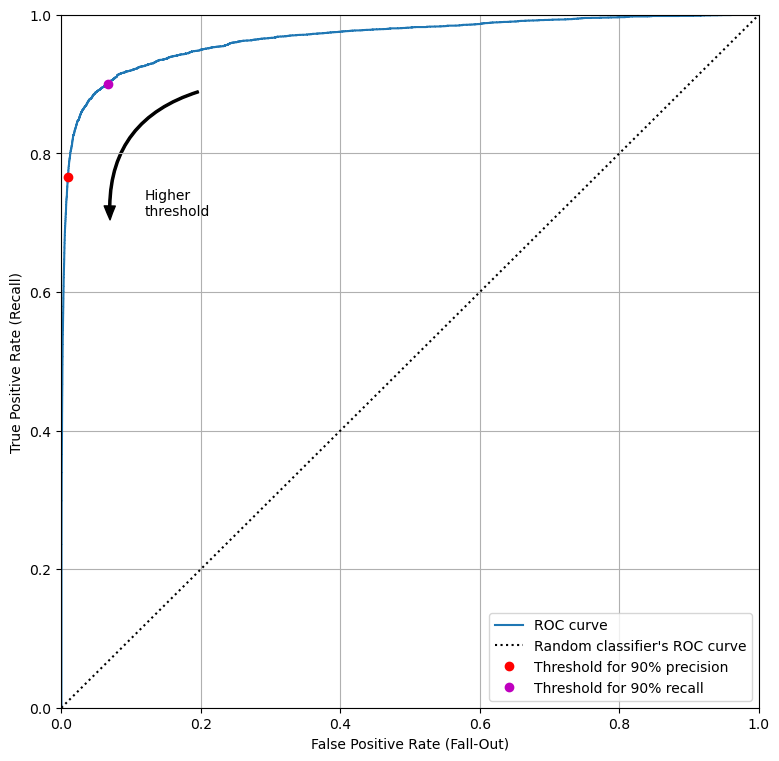

In [35]:
idx_for_threshold_at_90_precision = (thresholds <= threshold_for_90_precision).argmax()
tpr_90_precision, fpr_90_precision = tpr[idx_for_threshold_at_90_precision], fpr[idx_for_threshold_at_90_precision]

idx_for_threshold_at_90_recall = (thresholds <= threshold_for_90_recall).argmax()
tpr_90_recall, fpr_90_recall = tpr[idx_for_threshold_at_90_recall], fpr[idx_for_threshold_at_90_recall]

plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90_precision], [tpr_90_precision], 'ro', label='Threshold for 90% precision')
plt.plot([fpr_90_recall], [tpr_90_recall], 'mo', label='Threshold for 90% recall')

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle='arc3,rad=.4',
    arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
    color='k'))
plt.text(0.12, 0.71, 'Higher\nthreshold', color='k')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower right')

- Trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces
- The dotted $y=x$ diagonal line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards the top-left corner)
- Area under the curve (AUC) measures classifier performance, ranges from 0 to 1
  - Perfect classifier: ROC AUC = 1
  - Purely random classifier: ROC AUC = 0.5

Scikit-Learn function to estimate the ROC AUC:

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_select, y_scores)

0.9668761260481464

## 2.5. Comparing PR Curves of Random Forest vs SGD Classifiers

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=rng_state)

Using `method=predict_proba` with `cross_val_predict()` to retrieve decision scores of all instances in the training set

- `SGDClassifier`: `decision_function`
- `RandomForestClassifier`: `predict_proba`

In [38]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_select, cv=3, method='predict_proba')

Checking the probabilities for the first 10 images, the model pretty confidently predicts the negative images

In [39]:
y_probas_forest[:10]

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.2 , 0.8 ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ]])

These are estimated probabilities
- Among the images that the model classified as positive with a probability between 50% and 60%, roughly 94% of them are actually positive
- So, the model’s estimated probabilities were much too low in this case — but models can be overconfident as well

In [40]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f'{(y_train_select[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}')

90.4%


Plotting the PR Curve for the Random Forest Classifier

In [41]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_select, y_scores_forest)

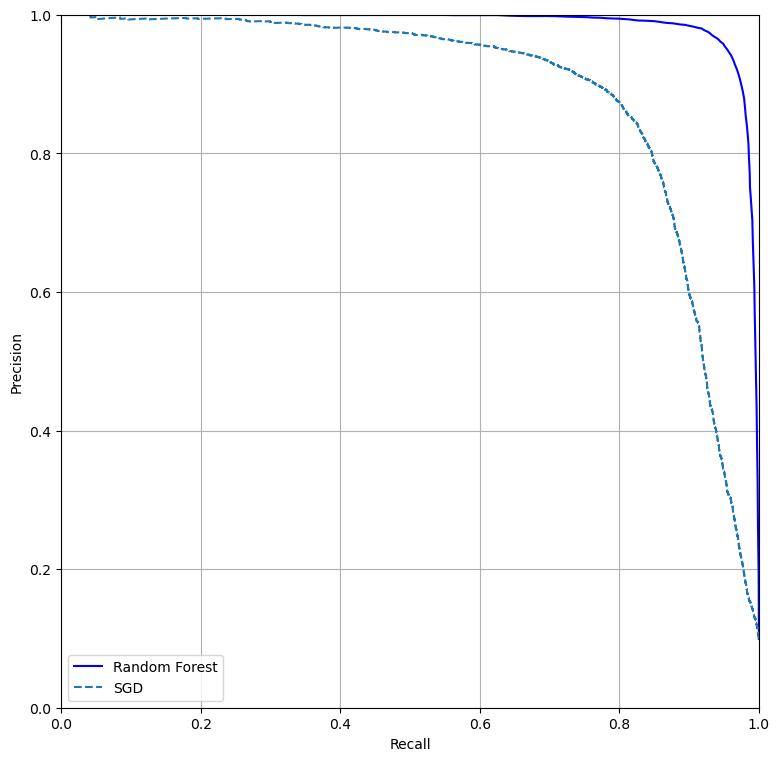

In [42]:
plt.figure(figsize=(9, 9))

plt.plot(recalls_forest, precisions_forest, 'b-', label='Random Forest')
plt.plot(recalls, precisions, '--', label='SGD')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower left')

The `RandomForestClassifier`’s PR curve looks much better than the `SGDClassifier`’s: it comes much closer to the top-right corner.

Its $F_1$ score and ROC AUC score are also significantly better

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [43]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_select, y_train_pred_forest)

0.9375219992960225

In [44]:
roc_auc_score(y_train_select, y_scores_forest)

0.9975984435986089

In [45]:
precision_score(y_train_select, y_train_pred_forest)

0.985386607473178

In [46]:
recall_score(y_train_select, y_train_pred_forest)

0.8940919771735482